O link em anexo contém 77 imagens de garrafas. Cada garrafa (no centro da imagem) pode possuir um ou mais dos seguintes 8 defeitos:

- CONTENT_HIGH,
- CONTENT_LOW,
- COVER_NONE,
- BOTTLE_SMASHED,
- LABEL_WHITE,
- LABEL_MISPLACED,
- LABEL_NONE,
- BOTTLE_NONE.

Cada indivíduo/grupo deverá submeter 1 arquivo de notebook (<nome do indivíduo/grupo>.ipynb) contendo uma função que receba uma imagem (numpy) e entregue um array (numpy) contendo 8 valores. Cada valor deve ser:
0 (para ausência do defeito correspondente), ou;
1 (para presença do defeito correspondente).

Requisitos:
1. Utilizar o Opencv 4.5.5.
2. Em cada imagem, considerar somente a garrafa do meio.
3. Trabalho individual ou em dupla. No caso de dupla, o grupo vai decidir a divisão dos pontos que será no mín. 0 e no máx. 20.
4. Utilizar somente técnicas referentes à disciplina de processamento de imagens, excetuando redes neurais.

In [ ]:
!pip install opencv-python==4.5.5.64 # precisei escolher o ultimo do 4.5.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from glob import glob; import csv; # para leitura de arquivos

In [65]:
def bottle_inspection(source_img):
  '''
  Sorted faults dictionary
  '''
  faults = {
    "CONTENT_HIGH": 0,
    "CONTENT_LOW": 0,
    "COVER_NONE": 0,
    "BOTTLE_SMASHED": 0,
    "LABEL_WHITE": 0,
    "LABEL_MISPLACED": 0,
    "LABEL_NONE": 0,
    "BOTTLE_NONE": 0
  }

  ''' Image segmentation
  '''
  img = cv2.cvtColor(source_img, cv2.COLOR_BGR2GRAY)
  ret, img_thresh = cv2.threshold(img,0,255,cv2.THRESH_OTSU)
  img_edges = cv2.Canny(img, 288, 150)
  
  kernel = np.ones((2,2),np.uint8)
  structuring_element = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

  ''' Extract central bottle
  '''
  h, w = img_thresh.shape
  middle = (w // 2) - 15
  # margin = 35 # middle_bottle = img_thresh[0:h, middle - margin:middle + margin]
  arr = np.argsort(np.sum(img_edges, axis=0))[:30] # lowests columns sum == space between bottles 
  try:
    middle_bottle = img_thresh[0:h, arr[np.argmax(arr < 140)]:arr[np.where(np.logical_and(arr < 300, arr > 200))][0]]
  except:
    faults["BOTTLE_NONE"] = 1
    return faults
  middle_bottle_edges = cv2.Canny(middle_bottle, 200, 150)
  if np.sum(middle_bottle_edges) < 26000: # no bottle
    faults["BOTTLE_NONE"] = 1
    return faults

  ''' Check smashed bottle
  '''
  middle_bottle_processed = cv2.morphologyEx(img[59:h-110, arr[np.argmax(arr < 140)]:arr[np.where(np.logical_and(arr < 300, arr > 200))][0]], cv2.MORPH_GRADIENT, structuring_element)
  middle_bottle_processed_edges = cv2.Canny(middle_bottle_processed, 200, 150)
  cols_sum = np.sum(middle_bottle_processed, axis=0)
  if np.sum(middle_bottle_processed_edges) > 50000:
    if (np.mean(cols_sum[:10]) < 1000) or (np.mean(cols_sum[len(cols_sum)-10:]) < 1000):
      faults["BOTTLE_SMASHED"] = 1
      # return faults

  ''' Check content level
  '''
  margin=5
  liquid_level = img_thresh[59:h-140, middle-margin:middle+margin]
  liquid_level_blurred = cv2.morphologyEx(liquid_level,cv2.MORPH_CLOSE,kernel, iterations = 2) # noise reduction
  liquid_level_processed = cv2.morphologyEx(liquid_level, cv2.MORPH_GRADIENT, structuring_element)
  liquid_level_edges = cv2.Canny(liquid_level_processed, 288, 150)
  if (np.sum(liquid_level_edges) < 2000) or (np.sum(liquid_level) > 207000) : # low level
     faults["CONTENT_LOW"] = 1
  else:
    if np.sum(liquid_level_edges[70:80]) < 1000: # check ranges
      faults["CONTENT_HIGH"] = 1
  
  ''' Check cover
  '''
  margin = 40
  cover = img_thresh[0:h-250, middle-margin:middle+margin]
  cover_processed = cv2.morphologyEx(cover, cv2.MORPH_GRADIENT, structuring_element)
  cover_edges = cv2.Canny(cover_processed, 288, 150)
  if np.sum(cover_edges) < 18000: # no cover
    faults["COVER_NONE"] = 1

  ''' Check label
  '''
  label = img_thresh[250:h-30, middle-margin:middle+margin]
  label_sum = np.sum(label)
  if label_sum < 1000:
    faults["LABEL_NONE"] = 1
  elif label_sum > 140000:
    faults["LABEL_WHITE"] = 1
  else:
    label_right_range = img_thresh[180:h-95, middle-margin:middle+margin+40]
    if np.max(np.sum(label_right_range, axis=1)) < 16000:
      faults["LABEL_MISPLACED"] = 1

  return faults


''' main
'''

for i in range(1,77):
  img_dir = f'train_{i}.jpg'
  # print(img_dir)
  img = cv2.imread(img_dir)
  current_value =  bottle_inspection(img);
  print(img_dir, current_value)


''' Debug
'''

# train_csv = csv.DictReader(open('train.csv', 'r'))
# train_dict = list(train_csv)

# print(bottle_inspection(cv2.imread('train_24.jpg')))

# for i in range(1,77):
#   img_dir = f'train_{i}.jpg'
#   # print(img_dir)
#   img = cv2.imread(img_dir)
#   train_csv_value = 1 if train_dict[i-1]["BOTTLE_SMASHED"] == '1' else 0
#   current_value =  bottle_inspection(img);
#   # assert_value = current_value["CONTENT_HIGH"] == train_csv_value
#   # assert_value = current_value["CONTENT_LOW"] == train_csv_value
#   # assert_value = current_value["COVER_NONE"] == train_csv_value
#   # assert_value = current_value["LABEL_WHITE"] == train_csv_value
#   # assert_value = current_value["LABEL_MISPLACED"] == train_csv_value
#   # assert_value = current_value["LABEL_NONE"] == train_csv_value
#   # assert_value = current_value["BOTTLE_NONE"] == train_csv_value
#   assert_value = current_value["BOTTLE_SMASHED"] == train_csv_value
#   if assert_value==False:
#     print(img_dir,current_value)
#     print(assert_value)

# for img_dir in glob('*.jpg'):
#   img = cv2.imread(img_dir)
#   print(img_dir, bottle_inspection(img))


train_1.jpg {'CONTENT_HIGH': 0, 'CONTENT_LOW': 0, 'COVER_NONE': 0, 'BOTTLE_SMASHED': 0, 'LABEL_WHITE': 0, 'LABEL_MISPLACED': 0, 'LABEL_NONE': 0, 'BOTTLE_NONE': 0}
train_2.jpg {'CONTENT_HIGH': 0, 'CONTENT_LOW': 0, 'COVER_NONE': 0, 'BOTTLE_SMASHED': 0, 'LABEL_WHITE': 0, 'LABEL_MISPLACED': 0, 'LABEL_NONE': 0, 'BOTTLE_NONE': 0}
train_3.jpg {'CONTENT_HIGH': 1, 'CONTENT_LOW': 0, 'COVER_NONE': 1, 'BOTTLE_SMASHED': 0, 'LABEL_WHITE': 0, 'LABEL_MISPLACED': 1, 'LABEL_NONE': 0, 'BOTTLE_NONE': 0}
train_4.jpg {'CONTENT_HIGH': 1, 'CONTENT_LOW': 0, 'COVER_NONE': 1, 'BOTTLE_SMASHED': 0, 'LABEL_WHITE': 0, 'LABEL_MISPLACED': 0, 'LABEL_NONE': 0, 'BOTTLE_NONE': 0}
train_5.jpg {'CONTENT_HIGH': 1, 'CONTENT_LOW': 0, 'COVER_NONE': 1, 'BOTTLE_SMASHED': 0, 'LABEL_WHITE': 0, 'LABEL_MISPLACED': 0, 'LABEL_NONE': 0, 'BOTTLE_NONE': 0}
train_6.jpg {'CONTENT_HIGH': 1, 'CONTENT_LOW': 0, 'COVER_NONE': 1, 'BOTTLE_SMASHED': 0, 'LABEL_WHITE': 0, 'LABEL_MISPLACED': 0, 'LABEL_NONE': 0, 'BOTTLE_NONE': 0}
train_7.jpg {'CONTENT_

' Debug\n'

# ###DRAFT

::::::::::Será que vale uma bolsa no Edge para trabalhar com visão computacional::::::::

In [63]:
def bottle_inspection(source_img):
  '''
  Sorted faults dictionary
  '''
  faults = {
    "CONTENT_HIGH": 0,
    "CONTENT_LOW": 0,
    "COVER_NONE": 0,
    "BOTTLE_SMASHED": 0,
    "LABEL_WHITE": 0,
    "LABEL_MISPLACED": 0,
    "LABEL_NONE": 0,
    "BOTTLE_NONE": 0
  }

  ''' Image segmentation
  '''
  img = cv2.cvtColor(source_img, cv2.COLOR_BGR2GRAY)
  ret, img_thresh = cv2.threshold(img,0,255,cv2.THRESH_OTSU)
  img_edges = cv2.Canny(img, 288, 150)
  
  kernel = np.ones((2,2),np.uint8)
  structuring_element = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

  ''' Extract central bottle
  '''
  h, w = img_thresh.shape
  middle = (w // 2) - 15
  # margin = 35 # middle_bottle = img_thresh[0:h, middle - margin:middle + margin]
  arr = np.argsort(np.sum(img_edges, axis=0))[:30] # lowests columns sum == space between bottles 
  try:
    middle_bottle = img_thresh[0:h, arr[np.argmax(arr < 140)]:arr[np.where(np.logical_and(arr < 300, arr > 200))][0]]
  except:
    faults["BOTTLE_NONE"] = 1
    return faults
  middle_bottle_edges = cv2.Canny(middle_bottle, 200, 150)
  if np.sum(middle_bottle_edges) < 26000: # no bottle
    faults["BOTTLE_NONE"] = 1
    return faults

  ''' Check smashed bottle
  '''
  middle_bottle_processed = cv2.morphologyEx(img[59:h-110, arr[np.argmax(arr < 140)]:arr[np.where(np.logical_and(arr < 300, arr > 200))][0]], cv2.MORPH_GRADIENT, structuring_element)
  middle_bottle_processed_edges = cv2.Canny(middle_bottle_processed, 200, 150)
  cols_sum = np.sum(middle_bottle_processed, axis=0)
  if np.sum(middle_bottle_processed_edges) > 50000:
    if (np.mean(cols_sum[:10]) < 1000) or (np.mean(cols_sum[len(cols_sum)-10:]) < 1000):
      faults["BOTTLE_SMASHED"] = 1
      # return faults

  ''' Check content level
  '''
  margin=5
  liquid_level = img_thresh[59:h-140, middle-margin:middle+margin]
  liquid_level_blurred = cv2.morphologyEx(liquid_level,cv2.MORPH_CLOSE,kernel, iterations = 2) # noise reduction
  liquid_level_processed = cv2.morphologyEx(liquid_level, cv2.MORPH_GRADIENT, structuring_element)
  liquid_level_edges = cv2.Canny(liquid_level_processed, 288, 150)
  if (np.sum(liquid_level_edges) < 2000) or (np.sum(liquid_level) > 207000) : # low level
     faults["CONTENT_LOW"] = 1
  else:
    if np.sum(liquid_level_edges[70:80]) < 1000: # check ranges
      faults["CONTENT_HIGH"] = 1
  
  ''' Check cover
  '''
  margin = 40
  cover = img_thresh[0:h-250, middle-margin:middle+margin]
  cover_processed = cv2.morphologyEx(cover, cv2.MORPH_GRADIENT, structuring_element)
  cover_edges = cv2.Canny(cover_processed, 288, 150)
  if np.sum(cover_edges) < 18000: # no cover
    faults["COVER_NONE"] = 1

  ''' Check label
  '''
  label = img_thresh[250:h-30, middle-margin:middle+margin]
  label_sum = np.sum(label)
  if label_sum < 1000:
    faults["LABEL_NONE"] = 1
  elif label_sum > 140000:
    faults["LABEL_WHITE"] = 1
  else:
    label_right_range = img_thresh[180:h-95, middle-margin:middle+margin+40]
    if np.max(np.sum(label_right_range, axis=1)) < 16000:
      faults["LABEL_MISPLACED"] = 1

  return faults


# for i in range(1,77):
#   img_dir = f'train_{i}.jpg'
#   # print(img_dir)
#   img = cv2.imread(img_dir)
#   current_value =  bottle_inspection(img);
#   print(img_dir, current_value)

train_csv = csv.DictReader(open('train.csv', 'r'))
train_dict = list(train_csv)

# print(bottle_inspection(cv2.imread('train_17.jpg')))

for i in range(1,77):
  img_dir = f'train_{i}.jpg'
  # print(img_dir)
  img = cv2.imread(img_dir)
  train_csv_value = 1 if train_dict[i-1]["BOTTLE_SMASHED"] == '1' else 0
  current_value =  bottle_inspection(img);
  # assert_value = current_value["CONTENT_HIGH"] == train_csv_value
  # assert_value = current_value["CONTENT_LOW"] == train_csv_value
  # assert_value = current_value["COVER_NONE"] == train_csv_value
  # assert_value = current_value["LABEL_WHITE"] == train_csv_value
  # assert_value = current_value["LABEL_MISPLACED"] == train_csv_value
  # assert_value = current_value["LABEL_NONE"] == train_csv_value
  # assert_value = current_value["BOTTLE_NONE"] == train_csv_value
  assert_value = current_value["BOTTLE_SMASHED"] == train_csv_value
  if assert_value==False:
    print(img_dir,current_value)
    print(assert_value)

# for img_dir in glob('*.jpg'):
#   img = cv2.imread(img_dir)
#   print(img_dir, bottle_inspection(img))








[115 116 114 237 238 243 242 241 240 239 113 236 117 228 230 229 244 257
 256 227 232 345 162 222 221 165 253 346 344 161 164 166 205 177 179 216
 223 224 343 342 235 350 175 351  11 349 199 180 151 202]
[237 238 243 242 241 240 239 236 228 230 229 244 257 256 227 232 222 221
 253 205 216 223 224 235 202]
203745
301589
[ 517  920 1330 1764 2050 2063 1898 1895 1964 1877 1868 1866 1935 1831
 1880 2263 2431 2420 2432 2327 2266 2220 2336 2479 2387 2353 2766 3109
 2957 2554 2334 2253 2342 2397 2256 2186 2259 2320 2149 2221 2349 2401
 2624 2513 2585 2637 2382 2465 2431 2120 2019 2140 2506 3601 4284 3507
 3125 3534 2962 2185 2079 2131 2426 2232 2268 2256 2038 1945 2024 2097
 1942 2184 2672 2812 2683 2675 2766 2757 2697 2662 2515 2429 2522 2569
 2795 3109 3196 3183 3250 3203 3107 3244 3271 2905 2630 2564 2567 2442
 3675 4748 4036 3717 4106 3790 3765 3736 3188 2806 3092 2972 4096 5300
 3245 1210  731  727  831  696  557  604  601  468]
2472.0409836065573 1627.8 967.0


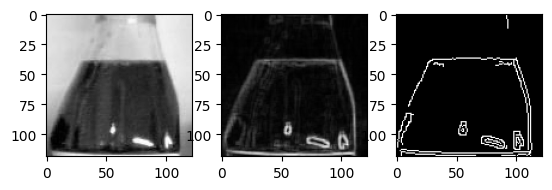

In [45]:
img = cv2.cvtColor(cv2.imread('train_42.jpg'), cv2.COLOR_BGR2GRAY)
ret, img_thresh = cv2.threshold(img,0,255,cv2.THRESH_OTSU)
kernel = np.ones((2,2),np.uint8)
img_thresh_noised = cv2.morphologyEx(img_thresh,cv2.MORPH_CLOSE,kernel, iterations = 2)

h, w = img_thresh.shape
middle = (w // 2) - 15
margin = 130
middle_bottle = img
middle_bottle_edges = cv2.Canny(middle_bottle, 288, 150)
arr = np.argsort(np.sum(middle_bottle_edges, axis=0))[:50]
print(arr)
print(arr[np.where(np.logical_and(arr < 300, arr > 200))])
a = arr[np.where(np.logical_and(arr < 300, arr > 200))][0]
# print(np.argsort(np.sum(middle_bottle_edges, axis=0))[:2])
plt.subplot(131)
img = img[59:h-110, arr[np.argmax(arr < 140)]:arr[np.where(np.logical_and(arr < 300, arr > 200))][0]]
plt.imshow(img, cmap='gray')


plt.subplot(132)
elemento_estruturante = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
liquid_level_processed = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, elemento_estruturante)
edges = cv2.Canny(liquid_level_processed, 288, 150)
plt.imshow(liquid_level_processed, cmap='gray')
col_sum = np.sum(liquid_level_processed, axis=0)
plt.subplot(133)
plt.imshow(edges, cmap='gray')
print(np.sum(edges))                  # 74 - 102255, 42 - 203745, 32 - 121380, 24 - 126480, 18 - 190740, 21 - 119850, 26 - 97665, # 1 - 117555, 23 - 114240
print(np.sum(liquid_level_processed)) # 74 - 226215, 42 - 301589, 32 - 269911, 24 - 242880, 18 - 236509, 21 - 237009,  26 - 220125, # 1 - 236509, 23 - 213609

cols_sum = np.sum(liquid_level_processed, axis=0)
print(cols_sum)
print(np.mean(cols_sum), np.mean(cols_sum[:10]), (np.mean(cols_sum[len(cols_sum)-10:])))

[114 239 240 237 212 256 251 252 265 255 266 267 268 269 257 250 264 254
 263 249 262 258 259 248 281 113 279 277 244 284 247 236 238 253 232 242
 278 241 285 280 283 292 291 290 289 288 287 286 276 275]
[239 240 237 212 256 251 252 265 255 266 267 268 269 257 250 264 254 263
 249 262 258 259 248 281 279 277 244 284 247 236 238 253 232 242 278 241
 285 280 283 292 291 290 289 288 287 286 276 275]
15810
133676
[ 748 1036 1114 1038  981 1016  984  975  947  916  893  905  935 1032
 1038 1028 1087 1129 1150 1034 1005 1013  957  927  821  826 1061 1177
 1131 1196 1162 1155 1152 1019  997 1047 1188 1262 1146 1120 1118 1081
 1094 1137 1143 1125  964  869  891  918  987 1001  936  821  798  741
  730  713  716  739  793  889 1084 1464 1454 1117 1054 1107 1148 1489
 1516 1176 1075 1194 1288 1166 1118 1114 1161 1213 1263 1256 1276 1290
 1216 1386 1559 1471 1289 1285 1245 1207 1150 1107 1045  934  947  965
  957  963  912 1139 1401 1278 1179 1009  913  966  830  919  983 1108
 1133 1089  971  96

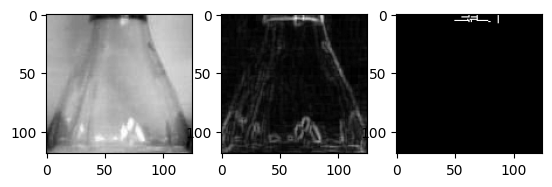

In [61]:
img = cv2.cvtColor(cv2.imread('train_49.jpg'), cv2.COLOR_BGR2GRAY)
ret, img_thresh = cv2.threshold(img,0,255,cv2.THRESH_OTSU)
kernel = np.ones((2,2),np.uint8)
img_thresh_noised = cv2.morphologyEx(img_thresh,cv2.MORPH_CLOSE,kernel, iterations = 2)

h, w = img_thresh.shape
middle = (w // 2) - 15
margin = 130
middle_bottle = img
middle_bottle_edges = cv2.Canny(middle_bottle, 288, 150)
arr = np.argsort(np.sum(middle_bottle_edges, axis=0))[:50]
print(arr)
print(arr[np.where(np.logical_and(arr < 300, arr > 200))])
a = arr[np.where(np.logical_and(arr < 300, arr > 200))][0]
# print(np.argsort(np.sum(middle_bottle_edges, axis=0))[:2])
plt.subplot(131)
img = img[59:h-110, arr[np.argmax(arr < 140)]:arr[np.where(np.logical_and(arr < 300, arr > 200))][0]]
plt.imshow(img, cmap='gray')


plt.subplot(132)
elemento_estruturante = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
liquid_level_processed = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, elemento_estruturante)
edges = cv2.Canny(liquid_level_processed, 288, 150)
plt.imshow(liquid_level_processed, cmap='gray')
col_sum = np.sum(liquid_level_processed, axis=0)
plt.subplot(133)
plt.imshow(edges, cmap='gray')
print(np.sum(edges))                  # 74 - 102255, 42 - 203745, 32 - 121380, 24 - 126480, 18 - 190740, 21 - 119850, 26 - 97665, # 1 - 117555, 23 - 114240
print(np.sum(liquid_level_processed)) # 74 - 226215, 42 - 301589, 32 - 269911, 24 - 242880, 18 - 236509, 21 - 237009,  26 - 220125, # 1 - 236509, 23 - 213609

cols_sum = np.sum(liquid_level_processed, axis=0)
print(cols_sum)
print(np.mean(cols_sum), np.mean(cols_sum[:10]), (np.mean(cols_sum[len(cols_sum)-10:])))

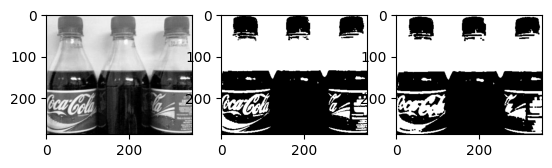

In [ ]:
img = cv2.cvtColor(cv2.imread('train_14.jpg'), cv2.COLOR_BGR2GRAY)
ret, img_thresh = cv2.threshold(img,0,255,cv2.THRESH_OTSU)

kernel = np.ones((2,2),np.uint8)
img_thresh_noised = cv2.morphologyEx(img_thresh,cv2.MORPH_CLOSE,kernel, iterations = 2)
# opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

''' Extrai garrafa central
'''
h, w = img_thresh.shape
middle = (w // 2) - 15
margin = 40
middle_bottle = img_thresh[0:h, middle - margin:middle + margin]
middle_bottle_edges = cv2.Canny(middle_bottle, 288, 150)
structuring_element = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.subplot(132)
plt.imshow(img_thresh, cmap='gray')
plt.subplot(133)
plt.imshow(img_thresh_noised, cmap='gray')

In [ ]:
# Load the images
img1 = cv2.imread('train_24.jpg')
img2 = cv2.imread('train_21.jpg')

h, w = img_thresh.shape
middle = (w // 2) - 15
margin = 40
img1 = img1[0:h, middle - margin:middle + margin]
img2 = img2[0:h, middle - margin:middle + margin]

# Calculate the histograms, and normalize them
hist_img1 = cv2.calcHist([img1], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
cv2.normalize(hist_img1, hist_img1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
hist_img2 = cv2.calcHist([img2], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
cv2.normalize(hist_img2, hist_img2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

# Find the metric value
metric_val1 = cv2.compareHist(hist_img1, hist_img2, cv2.HISTCMP_CORREL)
metric_val2 = cv2.compareHist(hist_img1, hist_img2, cv2.HISTCMP_CHISQR)
metric_val3 = cv2.compareHist(hist_img1, hist_img2, cv2.HISTCMP_INTERSECT)
metric_val4 = cv2.compareHist(hist_img1, hist_img2, cv2.HISTCMP_BHATTACHARYYA)
print("Metric Value using Correlation Hist Comp Method", metric_val1)
print("Metric Value using Chi Square Hist Comp Method", metric_val2)
print("Metric Value using Intersection Hist Comp Method", metric_val3)
print("Metric Value using Bhattacharyya Hist Comp Method", metric_val4)

Metric Value using Correlation Hist Comp Method 0.31232805780284073
Metric Value using Chi Square Hist Comp Method 593.9852283735914
Metric Value using Intersection Hist Comp Method 68.44444619398564
Metric Value using Bhattacharyya Hist Comp Method 0.8494202235002707


526575


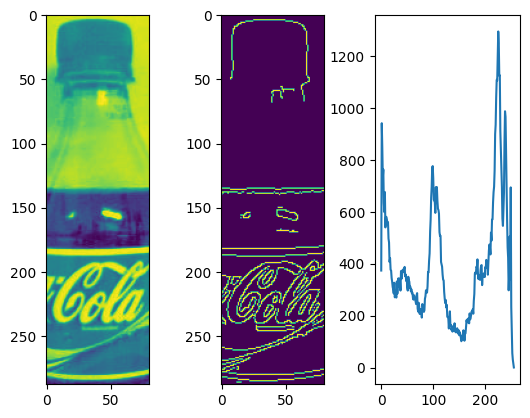

In [ ]:
img = cv2.cvtColor(cv2.imread('train_1.jpg'), cv2.COLOR_BGR2GRAY)
ret, img_thresh = cv2.threshold(img,0,255,cv2.THRESH_OTSU)
kernel = np.ones((3,3),np.uint8)
img_thresh_noised = cv2.morphologyEx(img_thresh,cv2.MORPH_CLOSE,kernel, iterations = 2)

h, w = img_thresh.shape
middle = (w // 2) - 15
margin = 40
middle_bottle = img[0:h, middle - margin:middle + margin]
middle_bottle_edges = cv2.Canny(middle_bottle, 288, 150)
plt.subplot(131)
plt.imshow(middle_bottle)
plt.subplot(132)
plt.imshow(middle_bottle_edges)
print(np.sum(middle_bottle_edges))
plt.subplot(133)
plt.plot(cv2.calcHist([img],[0],None,[256],[0,256]))

300390


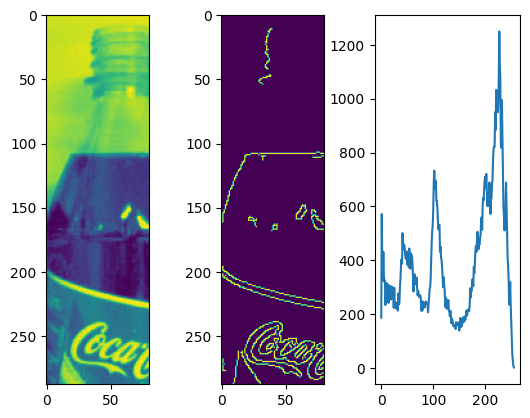

In [ ]:
img = cv2.cvtColor(cv2.imread('train_3.jpg'), cv2.COLOR_BGR2GRAY)
ret, img_thresh = cv2.threshold(img,0,255,cv2.THRESH_OTSU)
kernel = np.ones((3,3),np.uint8)
img_thresh_noised = cv2.morphologyEx(img_thresh,cv2.MORPH_CLOSE,kernel, iterations = 2)

h, w = img_thresh.shape
middle = (w // 2) - 15
margin = 40
middle_bottle = img[0:h, middle - margin:middle + margin]
middle_bottle_edges = cv2.Canny(middle_bottle, 288, 150)
plt.subplot(131)
plt.imshow(middle_bottle)
plt.subplot(132)
plt.imshow(middle_bottle_edges)
plt.subplot(133)
plt.plot(cv2.calcHist([img],[0],None,[256],[0,256]))
print(np.sum(middle_bottle_edges))

[351 222 223 224  92  93  94  95  96 331 336 337 338 335 249 248 237 250
 252 235 330 329 328 236 327 326 238 240 241 325 323 322 332 255 254 253
 239 256 324 346 339 333  91 334 258 228 247 234 251 321]
[222 223 224 249 248 237 250 252 235 236 238 240 241 255 254 253 239 256
 258 228 247 234 251]
[21.0, 123.0, 159.0, 162.0, 147.0, 111.0, 84.0, 85.0, 67.0, 74.0, 61.0, 61.0, 55.0, 52.0, 59.0, 53.0, 51.0, 56.0, 46.0, 53.0, 54.0, 60.0, 44.0, 41.0, 51.0, 51.0, 53.0, 49.0, 52.0, 47.0, 71.0, 48.0, 58.0, 55.0, 44.0, 71.0, 60.0, 56.0, 78.0, 81.0, 75.0, 95.0, 113.0, 92.0, 125.0, 131.0, 123.0, 122.0, 125.0, 128.0, 112.0, 110.0, 124.0, 106.0, 124.0, 105.0, 106.0, 106.0, 101.0, 126.0, 115.0, 104.0, 110.0, 104.0, 119.0, 109.0, 111.0, 102.0, 126.0, 131.0, 76.0, 94.0, 103.0, 98.0, 84.0, 98.0, 74.0, 76.0, 80.0, 111.0, 97.0, 93.0, 90.0, 96.0, 121.0, 114.0, 111.0, 122.0, 133.0, 132.0, 155.0, 171.0, 184.0, 168.0, 180.0, 189.0, 165.0, 151.0, 181.0, 193.0, 189.0, 184.0, 201.0, 199.0, 190.0, 210.0, 183.0, 2

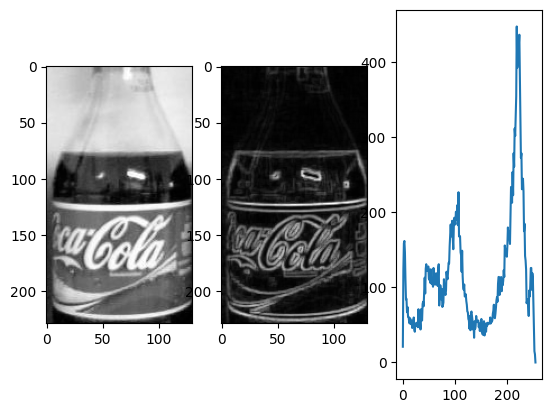

In [ ]:
img = cv2.cvtColor(cv2.imread('train_1.jpg'), cv2.COLOR_BGR2GRAY)
ret, img_thresh = cv2.threshold(img,0,255,cv2.THRESH_OTSU)
kernel = np.ones((2,2),np.uint8)
img_thresh_noised = cv2.morphologyEx(img_thresh,cv2.MORPH_CLOSE,kernel, iterations = 2)

h, w = img_thresh.shape
middle = (w // 2) - 15
margin = 130
middle_bottle = img
middle_bottle_edges = cv2.Canny(middle_bottle, 288, 150)
arr = np.argsort(np.sum(middle_bottle_edges, axis=0))[:50]
print(arr)
print(arr[np.where(np.logical_and(arr < 300, arr > 200))])
a = arr[np.where(np.logical_and(arr < 300, arr > 200))][0]
# print(np.argsort(np.sum(middle_bottle_edges, axis=0))[:2])

plt.subplot(131)
img = img[59:h, arr[np.argmax(arr < 140)]:arr[np.where(np.logical_and(arr < 300, arr > 200))][0]]
plt.imshow(img, cmap='gray')


plt.subplot(132)
elemento_estruturante = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
liquid_level_processed = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, elemento_estruturante)
edges = cv2.Canny(liquid_level_processed, 288, 150)
plt.imshow(liquid_level_processed, cmap='gray')

hist = cv2.calcHist([img],[0],None,[256],[0,256])
print(hist.flatten().tolist())

plt.subplot(133)
plt.plot(hist)
print(np.sum(liquid_level_processed))

[112 114 115 116 113 117 118 244 243 241 135 239 128 245 119 240 136 138
 129 124 130 125 127 123 126 238 120 242 131 342 133 149 257 248 137 351
 172 171 345 350 177 232 253 250 346 343 256 252 141 140]
[244 243 241 239 245 240 238 242 257 248 232 253 250 256 252]
[22.0, 90.0, 176.0, 179.0, 221.0, 171.0, 166.0, 167.0, 111.0, 129.0, 158.0, 129.0, 119.0, 156.0, 127.0, 155.0, 169.0, 169.0, 162.0, 139.0, 189.0, 145.0, 152.0, 155.0, 119.0, 162.0, 136.0, 133.0, 145.0, 113.0, 128.0, 127.0, 103.0, 111.0, 105.0, 107.0, 145.0, 143.0, 192.0, 228.0, 238.0, 308.0, 257.0, 260.0, 278.0, 275.0, 249.0, 228.0, 222.0, 253.0, 213.0, 201.0, 212.0, 189.0, 252.0, 195.0, 179.0, 198.0, 186.0, 224.0, 204.0, 167.0, 148.0, 185.0, 193.0, 180.0, 185.0, 182.0, 181.0, 155.0, 140.0, 155.0, 145.0, 145.0, 136.0, 126.0, 116.0, 102.0, 113.0, 92.0, 108.0, 109.0, 101.0, 96.0, 90.0, 107.0, 108.0, 99.0, 97.0, 95.0, 93.0, 103.0, 95.0, 116.0, 121.0, 134.0, 153.0, 164.0, 172.0, 178.0, 185.0, 201.0, 186.0, 166.0, 153.0, 161.0, 1

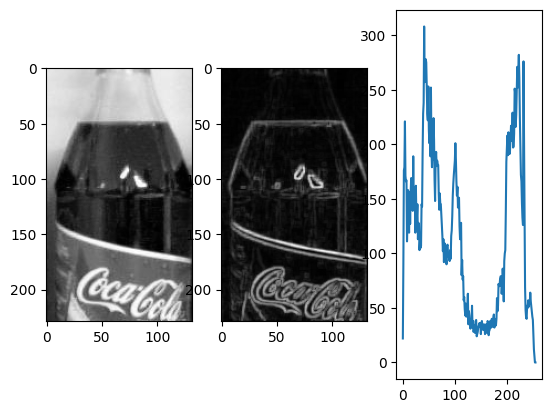

In [9]:
img = cv2.cvtColor(cv2.imread('train_3.jpg'), cv2.COLOR_BGR2GRAY)
ret, img_thresh = cv2.threshold(img,0,255,cv2.THRESH_OTSU)
kernel = np.ones((2,2),np.uint8)
img_thresh_noised = cv2.morphologyEx(img_thresh,cv2.MORPH_CLOSE,kernel, iterations = 2)

h, w = img_thresh.shape
middle = (w // 2) - 15
margin = 130
middle_bottle = img
middle_bottle_edges = cv2.Canny(middle_bottle, 288, 150)
arr = np.argsort(np.sum(middle_bottle_edges, axis=0))[:50]
print(arr)
print(arr[np.where(np.logical_and(arr < 300, arr > 200))])
a = arr[np.where(np.logical_and(arr < 300, arr > 200))][0]
# print(np.argsort(np.sum(middle_bottle_edges, axis=0))[:2])

plt.subplot(131)
img = img[59:h, arr[np.argmax(arr < 140)]:arr[np.where(np.logical_and(arr < 300, arr > 200))][0]]
plt.imshow(img, cmap='gray')


plt.subplot(132)
elemento_estruturante = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
liquid_level_processed = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, elemento_estruturante)
edges = cv2.Canny(liquid_level_processed, 288, 150)
plt.imshow(liquid_level_processed, cmap='gray')

hist = cv2.calcHist([img],[0],None,[256],[0,256])
print(hist.flatten().tolist())

plt.subplot(133)
plt.plot(hist)
print(np.sum(liquid_level_processed))

[351 222 223 224  92  93  94  95  96 331 336 337 338 335 249 248 237 250
 252 235 330 329 328 236 327 326 238 240 241 325 323 322 332 255 254 253
 239 256 324 346 339 333  91 334 258 228 247 234 251 321]
[222 223 224 249 248 237 250 252 235 236 238 240 241 255 254 253 239 256
 258 228 247 234 251]
[1672 2050 1888 2205 3629 6121 7332 6806 6368 6728 7044 7059 6922 6845
 7163 7222 7179 7546 7273 6821 6976 7107 7377 7314 7608 7722 7706 8303
 8129 7690 7517 7139 7316 7913 8410 8240 7623 7277 6930 6786 7368 7911
 8138 8413 8523 8107 8266 8452 8449 8491 8872 8791 8603 8066 8298 8604
 8425 8086 8035 7849 7638 7781 8157 8507 8793 8694 8549 8786 9395 9341
 8383 9095 9658 8759 7868 7820 7361 7136 7598 8177 8600 8748 8700 9048
 9312 9150 9169 9384 9569 8884 8748 9068 9362 8808 8637 8412 8084 7789
 8247 7921 7613 7565 7431 7474 7441 6765 6354 6272 6734 7642 7664 6840
 6785 6705 6151 6123 5939 4875 4706 5018 5501 5729 6084 6538 6239 5989
 6152 6441 6593 4297]
7442.3
130
7285.830769230769
7598.769230

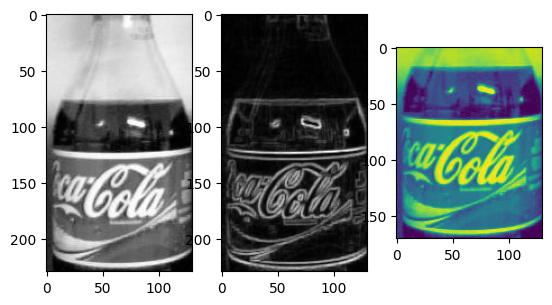

In [ ]:
img = cv2.cvtColor(cv2.imread('train_1.jpg'), cv2.COLOR_BGR2GRAY)
ret, img_thresh = cv2.threshold(img,0,255,cv2.THRESH_OTSU)
kernel = np.ones((2,2),np.uint8)
img_thresh_noised = cv2.morphologyEx(img_thresh,cv2.MORPH_CLOSE,kernel, iterations = 2)

h, w = img_thresh.shape
middle = (w // 2) - 15
margin = 130
middle_bottle = img
middle_bottle_edges = cv2.Canny(middle_bottle, 288, 150)
arr = np.argsort(np.sum(middle_bottle_edges, axis=0))[:50]
print(arr)
print(arr[np.where(np.logical_and(arr < 300, arr > 200))])
a = arr[np.where(np.logical_and(arr < 300, arr > 200))][0]
# print(np.argsort(np.sum(middle_bottle_edges, axis=0))[:2])
plt.subplot(131)
img = img[59:h, arr[np.argmax(arr < 140)]:arr[np.where(np.logical_and(arr < 300, arr > 200))][0]]
plt.imshow(img, cmap='gray')


plt.subplot(132)
elemento_estruturante = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
liquid_level_processed = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, elemento_estruturante)
edges = cv2.Canny(liquid_level_processed, 288, 150)
plt.imshow(liquid_level_processed, cmap='gray')

col_sum = np.sum(liquid_level_processed, axis=0)
print(col_sum)
print(np.mean(col_sum))
print(len(col_sum))
print(np.mean(col_sum[:len(col_sum)//2]))
print(np.mean(col_sum[len(col_sum)//2:]))
print("max:", np.max(col_sum))
plt.subplot(133)
print(np.sum(liquid_level_processed))
# plt.imshow(edges, cmap='gray')
# col_sum = np.sum(edges, axis=0)
# print("edges")
# print(np.mean(col_sum))
# print(len(col_sum))
# print(np.mean(col_sum[:10]))
# print(np.mean(col_sum[len(col_sum)-10:]))
plt.imshow(img[59:h,])

[249 255 254 253 252 251 250 248 247 256 246 244 243 242 127 128 129 130
 131 245 257 132 259 260 261 262 263 264 265 266 267 268 269 270 271 258
 272 126   0 133 274 241 134 230 229 228 227 273  55 188]
[249 255 254 253 252 251 250 248 247 256 246 244 243 242 245 257 259 260
 261 262 263 264 265 266 267 268 269 270 271 258 272 274 241 230 229 228
 227 273]
[ 1824  1987  1418  1659  1877  2039  2308  2523  3978  5116  5308  5491
  6544  7573  7613  7588  8151  8064  8066  8227  7740  7550  7202  7030
  7390  7750  7866  7638  7459  7601  7571  8166  8018  7616  7274  6986
  6963  7095  6422  6102  8829 10153  7946  5772  5103  5077  5019  5013
  5298  6048  6524  6456  6188  6220  6577  6529  6609  6914  6420  6439
  6566  6701  6496  6211  6344  6130  6500  7203  6399  6243  8058  8489
  6665  5467  5101  4997  4785  4854  5075  5544  6309  6925  7162  7185
  7269  7302  7074  6985  6900  6632  6289  5959  5987  6597  7605  7621
  6063  5008  4730  4581  4483  4235  4319  4632  5322  

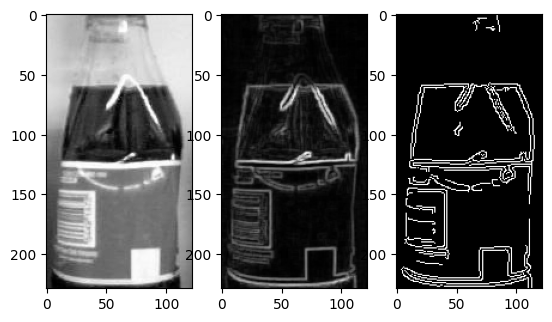

In [ ]:
img = cv2.cvtColor(cv2.imread('train_18.jpg'), cv2.COLOR_BGR2GRAY)
ret, img_thresh = cv2.threshold(img,0,255,cv2.THRESH_OTSU)
kernel = np.ones((2,2),np.uint8)
img_thresh_noised = cv2.morphologyEx(img_thresh,cv2.MORPH_CLOSE,kernel, iterations = 2)

h, w = img_thresh.shape
middle = (w // 2) - 15
margin = 130
middle_bottle = img
middle_bottle_edges = cv2.Canny(middle_bottle, 288, 150)
arr = np.argsort(np.sum(middle_bottle_edges, axis=0))[:50]
print(arr)
print(arr[np.where(np.logical_and(arr < 300, arr > 200))])
a = arr[np.where(np.logical_and(arr < 300, arr > 200))][0]
# print(np.argsort(np.sum(middle_bottle_edges, axis=0))[:2])
plt.subplot(131)
img = img[59:h, arr[np.argmax(arr < 140)]:arr[np.where(np.logical_and(arr < 300, arr > 200))][0]]
plt.imshow(img, cmap='gray')


plt.subplot(132)
elemento_estruturante = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
liquid_level_processed = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, elemento_estruturante)
edges = cv2.Canny(liquid_level_processed, 288, 150)
plt.imshow(liquid_level_processed, cmap='gray')
col_sum = np.sum(liquid_level_processed, axis=0)
print(col_sum)
print(np.mean(col_sum))
print(len(col_sum))
print(np.mean(col_sum[:9]))
print(np.mean(col_sum[len(col_sum)-9:]))
print("max:", np.max(col_sum))
plt.subplot(133)
plt.imshow(edges, cmap='gray')
print(np.sum(liquid_level_processed))

1904340
[112 114 115 116 113 117 118 244 243 241 135 239 128 245 119 240 136 138
 129 124 130 125 127 123 126 238 120 242 131 342 133 149 257 248 137 351
 172 171 345 350 177 232 253 250 346 343 256 252 141 140]
[244 243 241 239 245 240 238 242 257 248 232 253 250 256 252]


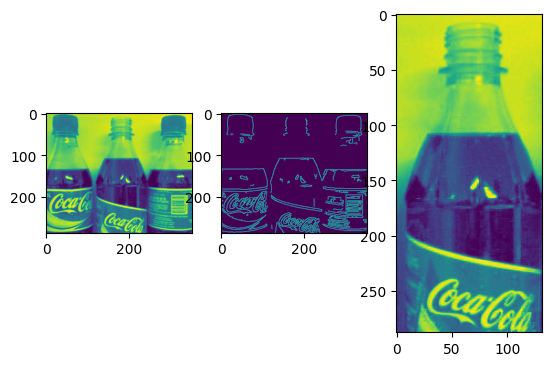

In [ ]:
img = cv2.cvtColor(cv2.imread('train_3.jpg'), cv2.COLOR_BGR2GRAY)
ret, img_thresh = cv2.threshold(img,0,255,cv2.THRESH_OTSU)
kernel = np.ones((2,2),np.uint8)
img_thresh_noised = cv2.morphologyEx(img_thresh,cv2.MORPH_CLOSE,kernel, iterations = 2)

h, w = img_thresh.shape
middle = (w // 2) - 15
margin = 130
middle_bottle = img
middle_bottle_edges = cv2.Canny(middle_bottle, 288, 150)
plt.subplot(131)
plt.imshow(middle_bottle)
plt.subplot(132)
plt.imshow(middle_bottle_edges)
print(np.sum(middle_bottle_edges))
plt.subplot(133)
# plt.plot(cv2.calcHist([img],[0],None,[256],[0,256]))
arr = np.argsort(np.sum(middle_bottle_edges, axis=0))[:50]
print(arr)
print(arr[np.where(np.logical_and(arr < 300, arr > 200))])
a = arr[np.where(np.logical_and(arr < 300, arr > 200))][0]
# print(np.argsort(np.sum(middle_bottle_edges, axis=0))[:2])
plt.imshow(img[0:h, arr[np.argmax(arr < 140)]:arr[np.where(np.logical_and(arr < 300, arr > 200))][0]])

99195 (8, 80)
13515


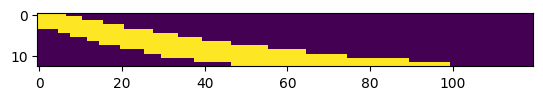

In [ ]:
''' Check label
  '''
label = img_thresh[230:h-50, middle-margin:middle+margin]
margin = 40
label_right_range = img_thresh[180:h-95, middle-margin:middle+margin+40]
label_sum = np.sum(label_right_range)
print(label_sum, label.shape)
plt.imshow(label_right_range)
print(np.max(np.sum(label_right_range, axis=1)))
# if label_sum < 1000:
#   faults["LABEL_NONE"] = 1
# elif label_sum > 75000:
#   faults["LABEL_WHITE"] = 1
# else:
#   label_right_range = img_thresh[180:h-100, middle-margin:middle+margin]
#   if np.sum(label_right_range) < 35000:
#     faults["LABEL_MISPLACED"] = 1

In [ ]:
margin = 40
cover = img_thresh[0:h-250, middle-margin:middle+margin]
cover_processed = cv2.morphologyEx(cover, cv2.MORPH_GRADIENT, structuring_element)
cover_edges = cv2.Canny(cover_processed, 288, 150)

print(np.sum(cover_edges))

plt.subplot(131)
plt.imshow(cover)
plt.subplot(132)
plt.imshow(cover_processed)
plt.subplot(133)
plt.imshow(cover_edges)

In [ ]:
margin=5
liquid_level = img_thresh[59:h-140, middle-margin:middle+margin]
kernel = np.ones((2,2),np.uint8)
liquid_level_blurred = cv2.morphologyEx(liquid_level,cv2.MORPH_CLOSE,kernel, iterations = 2) # noise reduction
structuring_element = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
liquid_level_processed = cv2.morphologyEx(liquid_level, cv2.MORPH_GRADIENT, structuring_element)
liquid_level_edges = cv2.Canny(liquid_level_processed, 288, 150)

print(np.sum(liquid_level))
print(np.sum(liquid_level_edges), len(liquid_level_edges), liquid_level_edges.shape)

# print(np.sum(liquid_level_edges, axis=1))

print(np.sum(liquid_level_edges[75:80]))
print(liquid_level_edges[70:80])

plt.subplot(131)
plt.imshow(liquid_level)
plt.subplot(132)
plt.imshow(liquid_level_processed)
plt.subplot(133)
plt.imshow(liquid_level_edges)

In [ ]:
margin = 20
img2 = img_thresh[180:h-100, middle-margin:middle+margin]
img_processed = cv2.morphologyEx(img2, cv2.MORPH_GRADIENT, structuring_element)
img_edges = cv2.Canny(img_processed, 288, 150)
plt.imshow(img2, cmap='gray')
print(np.sum(img2), len(img2), img2.shape)

In [ ]:
img_processed = cv2.morphologyEx(img_thresh, cv2.MORPH_GRADIENT, structuring_element)
img_edges = cv2.Canny(img_processed, 288, 150)
plt.imshow(img_processed)

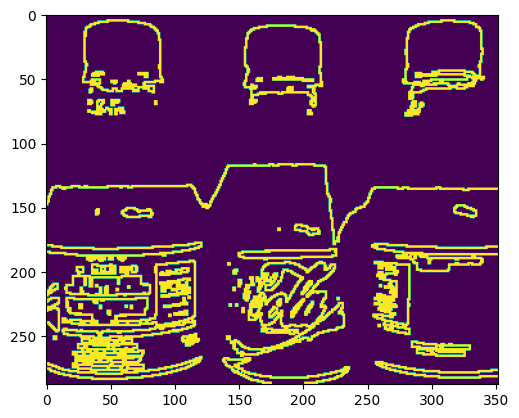

In [ ]:
img = cv2.imread('train_24.jpg')

# imageThresholded = np.where(imageCV>=180, 255, 0).astype(np.uint8)

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU) # cv2.THRESH_BINARY_INV+
# noise removal
kernel = np.ones((2,2),np.uint8)
# opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
closing = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE,kernel, iterations = 2)
# sure background area
sure_bg = cv2.dilate(closing,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(sure_bg,cv2.DIST_L2,3)
# Threshold
ret, sure_fg = cv2.threshold(dist_transform,0.1*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

elemento_estruturante = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
liquid_level_processed = cv2.morphologyEx(thresh, cv2.MORPH_GRADIENT, elemento_estruturante)
edges = cv2.Canny(thresh, 288, 150)

plt.imshow(liquid_level_processed)

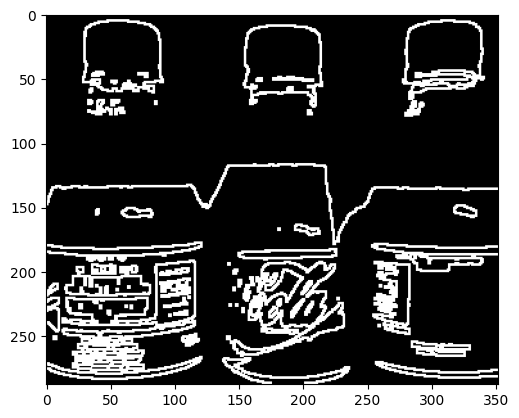

In [ ]:
elemento_estruturante = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
liquid_level_processed = cv2.morphologyEx(img_thresh, cv2.MORPH_GRADIENT, elemento_estruturante)
edges = cv2.Canny(liquid_level_processed, 288, 150)
plt.imshow(liquid_level_processed, cmap='gray')

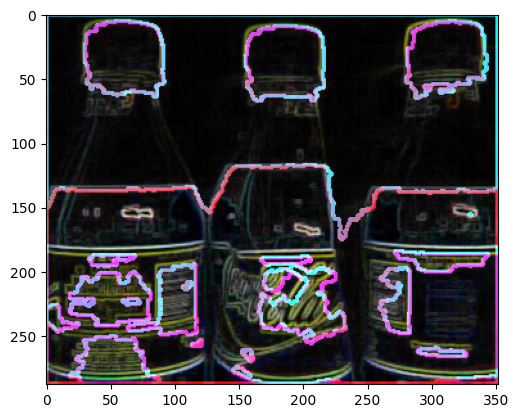

In [ ]:



liquid_level = img[100:h-120, middle - margin:middle + margin] # faixa 

# blur
# kernel_size = 5
# img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

# img = cv2.blur(img, (kernel_size, kernel_size))

# img = np.where(img>=127, 255, 0).astype(np.uint8)

# laplacian = cv2.Laplacian(img,cv2.CV_64F)

# edges = cv2.Canny(img, 288, 135)



# ''' para captar a altura do liquido
# eu pego a
# '''
# valores, contagens = np.unique(np.nonzero(edges), return_counts=True)

# for valor, contagem in zip(valores, contagens):
#     if contagem > 1:
#         print("Valor:", valor, "Contagem:", contagem)

# for  a in laplacian:
#   print(a)

elemento_estruturante = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
liquid_level_processed = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, elemento_estruturante)
edges = cv2.Canny(liquid_level_processed, 288, 150)
plt.imshow(liquid_level_processed)

# for a in edges:
#   print(a)

# plt.imshow(edges, cmap='gray')
plt.show()

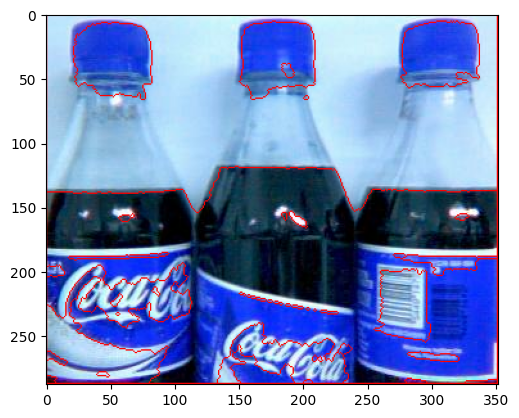

In [ ]:
plt.imshow(img, cmap='gray')

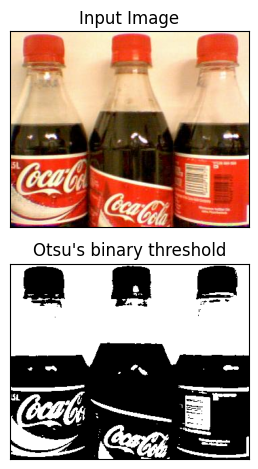

In [ ]:
#img = cv2.cvtColor(cv2.imread('train_1.jpg'), cv2.COLOR_BGR2GRAY) # retorna uma matriz numpy

img = cv2.imread('train_33.jpg')

# imageThresholded = np.where(imageCV>=180, 255, 0).astype(np.uint8)

b,g,r = cv2.split(img)
rgb_img = cv2.merge([r,g,b])
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU) # cv2.THRESH_BINARY_INV+
# noise removal
kernel = np.ones((2,2),np.uint8)
#opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
closing = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE,kernel, iterations = 2)
# sure background area
sure_bg = cv2.dilate(closing,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(sure_bg,cv2.DIST_L2,3)
# Threshold
ret, sure_fg = cv2.threshold(dist_transform,0.1*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]
plt.subplot(211),plt.imshow(rgb_img)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(212),plt.imshow(thresh, 'gray')
plt.imsave(r'thresh.png',thresh)
plt.title("Otsu's binary threshold"), plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show()


In [ ]:
def bottle_inspection(source_img):
  '''
  Sorted faults dictionary
  '''
  faults = {
    "CONTENT_HIGH": 0,
    "CONTENT_LOW": 0,
    "COVER_NONE": 0,
    "BOTTLE_SMASHED": 0,
    "LABEL_WHITE": 0,
    "LABEL_MISPLACED": 0,
    "LABEL_NONE": 0,
    "BOTTLE_NONE": 0
  }

  ''' Image segmentation
  '''
  img = cv2.cvtColor(source_img, cv2.COLOR_BGR2GRAY)
  ret, img_thresh = cv2.threshold(img,0,255,cv2.THRESH_OTSU)
  
  ''' Extract central bottle
  '''
  h, w = img_thresh.shape
  middle = (w // 2) - 15
  margin = 35
  middle_bottle = img_thresh[0:h, middle - margin:middle + margin]
  middle_bottle_edges = cv2.Canny(middle_bottle, 288, 150)
  if np.sum(middle_bottle_edges) < 26000: # no bottle
    faults["BOTTLE_NONE"] = 1
    return faults
  
  ''' Check content level
  '''
  margin=5
  liquid_level = img_thresh[59:h-140, middle-margin:middle+margin]
  kernel = np.ones((2,2),np.uint8)
  liquid_level_blurred = cv2.morphologyEx(liquid_level,cv2.MORPH_CLOSE,kernel, iterations = 2) # noise reduction
  structuring_element = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
  liquid_level_processed = cv2.morphologyEx(liquid_level, cv2.MORPH_GRADIENT, structuring_element)
  liquid_level_edges = cv2.Canny(liquid_level_processed, 288, 150)
  if (np.sum(liquid_level_edges) < 2000) or (np.sum(liquid_level) > 207000) : # low level
     faults["CONTENT_LOW"] = 1
  else:
    if np.sum(liquid_level_edges[70:80]) < 1000: # check ranges
      faults["CONTENT_HIGH"] = 1
  
  ''' Check cover
  '''
  margin = 40
  cover = img_thresh[0:h-250, middle-margin:middle+margin]
  cover_processed = cv2.morphologyEx(cover, cv2.MORPH_GRADIENT, structuring_element)
  cover_edges = cv2.Canny(cover_processed, 288, 150)
  if np.sum(cover_edges) < 18000: # no cover
    faults["COVER_NONE"] = 1

  ''' Check label
  '''
  label = img_thresh[250:h-30, middle-margin:middle+margin]
  label_sum = np.sum(label)
  if label_sum < 1000:
    faults["LABEL_NONE"] = 1
  elif label_sum > 140000:
    faults["LABEL_WHITE"] = 1
  else:
    label_right_range = img_thresh[180:h-95, middle-margin:middle+margin+40]
    if np.max(np.sum(label_right_range, axis=1)) < 16000:
      faults["LABEL_MISPLACED"] = 1

  return faults


train_csv = csv.DictReader(open('train.csv', 'r'))
train_dict = list(train_csv)

# print(bottle_inspection(cv2.imread('train_49.jpg')))

for i in range(1,77):
  img_dir = f'train_{i}.jpg'
  img = cv2.imread(img_dir)
  train_csv_value = 1 if train_dict[i-1]["CONTENT_HIGH"] == '1' else 0
  current_value =  bottle_inspection(img);
  assert_value = current_value["CONTENT_HIGH"] == train_csv_value
  # assert_value = current_value["CONTENT_LOW"] == train_csv_value
  # assert_value = current_value["COVER_NONE"] == train_csv_value
  # assert_value = current_value["LABEL_WHITE"] == train_csv_value
  # assert_value = current_value["LABEL_MISPLACED"] == train_csv_value
  if assert_value==False:
    print(img_dir,current_value)
    print(assert_value)

# for img_dir in glob('*.jpg'):
#   img = cv2.imread(img_dir)
#   print(img_dir, bottle_inspection(img))








train_24.jpg {'CONTENT_HIGH': 1, 'CONTENT_LOW': 0, 'COVER_NONE': 0, 'BOTTLE_SMASHED': 0, 'LABEL_WHITE': 0, 'LABEL_MISPLACED': 0, 'LABEL_NONE': 0, 'BOTTLE_NONE': 0}
False
